In [1]:
!pip install TurkishStemmer gensim unicode_tr

In [2]:

import numpy as np
import pandas as pd
import re
import nltk
import string
from nltk.corpus import stopwords
from TurkishStemmer import TurkishStemmer
from unicode_tr import unicode_tr

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_curve, auc, f1_score, roc_auc_score

import warnings; warnings.simplefilter('ignore')
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

#### WordNet, 200'den fazla dilde kelimeler arasındaki anlamsal ilişkilerin sözcüksel bir veritabanıdır. WordNet, kelimeleri eşanlamlılar, hiponimler ve meronimleri içeren anlamsal ilişkilere bağlar. 
#### Stopwords etkisiz kelimeler, doğal data dilinin işlenmeden önce veya sonra filtrelenmiş kelimeleridir.

In [3]:
download_list = ["stopwords","wordnet"]
for download in download_list:
    nltk.download(download)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\myavu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\myavu\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [5]:
data = pd.read_csv("./classification_clean.csv")
data.head()

,id,Title,Categories,Status,Date,Slug
0,18,"Küba Milli Takımı Oyuncularının, Bir Kadına Te...",SICAK,publish,2016-07-04,kuba-milli-takimi-oyuncularinin-bir-kadina-tec...
1,21,Daily Telegraph: 'Suriyelilere Vatandaşlık Tek...,SICAK,publish,2016-07-04,daily-telegraph-suriyelilere-vatandaslik-tekli...
2,24,AYM'den 'Yüksek Sesli Ezan' Şikayetine Ret,SICAK,publish,2016-07-04,aymden-yuksek-sesli-ezan-sikayetine-ret
3,31,"İstanbul'daki Terör Saldırısı, Eto'o'nun Düzen...",SICAK,publish,2016-07-04,istanbuldaki-teror-saldirisi-etoonun-duzenleye...
4,34,"Türkiye, Rusya'daki En Popüler Destinasyon Lid...",SICAK,publish,2016-07-04,turkiye-rusyadaki-en-populer-destinasyon-lider...


In [7]:
list(data['Categories'].value_counts().index)

['SICAK',
 'GÜNDEM',
 'DÜNYA',
 'SPOR',
 'GÜNDEM|SICAK',
 'DÜNYA|SICAK',
 'SANAT',
 'DÜNYA|GÜNDEM',
 'Teknoloji',
 'Video',
 'DÜNYA|SPOR',
 'DÜNYA|Teknoloji',
 'SICAK|SPOR',
 'GÜNDEM|SPOR',
 'DÜNYA|SANAT',
 'SANAT|Video',
 'DÜNYA|Video',
 'GÜNDEM|SANAT',
 'SPOR|Video',
 'GÜNDEM|Teknoloji',
 'DÜNYA|GÜNDEM|SPOR',
 'GÜNDEM|Video',
 'DÜNYA|GÜNDEM|SICAK',
 'News',
 'DÜNYA|Teknoloji|Video',
 'SICAK|Teknoloji',
 'SICAK|Video',
 'SANAT|SICAK',
 'SPOR|Teknoloji',
 'DÜNYA|GÜNDEM|SANAT']

#### Tekrarlı kategoriler yer aldığından dolayı seçili kategoriler filtrelenir

In [8]:
main_categories = ['DÜNYA', 'SPOR','SANAT','Teknoloji']
filter = data["Categories"].isin(main_categories)
data = data[filter]
new_data = data[['Title', 'Categories']]
new_data.head()

,Title,Categories
12006,58 Saniyede Katar Meselesi? Katar krizi nedir?...,DÜNYA
12496,58 Saniyede Türkiye - Almanya Gerginliği,DÜNYA
12877,"Adriana Lima, Bomba Aşkla İlgili İlk Kez Konuş...",DÜNYA
12878,Galatasaraylı Taraftarlar Patladı: İstifa Edin,SPOR
12880,"Galatasaray'dan Ayrılan Sabri, Neredeyse Bedav...",SPOR


In [9]:
new_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11622 entries, 12006 to 43762
Data columns (total 2 columns):
Title         11622 non-null object
Categories    11622 non-null object
dtypes: object(2)
memory usage: 272.4+ KB


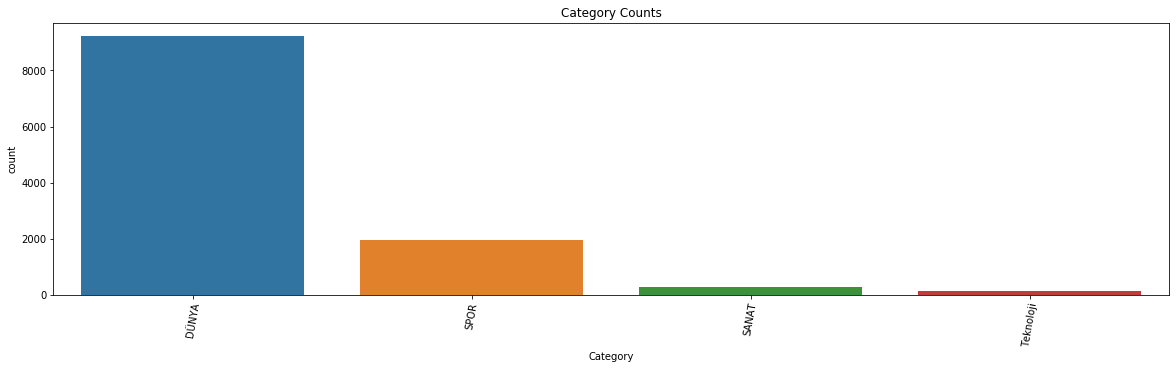

In [10]:
figure, ax = plt.subplots(1, 1, figsize = (20, 5))

ax = sns.countplot(new_data['Categories'])
ax.set_title("Category Counts")
ax.set_xlabel("Category")
# Manipulate the labels to make them more readable
ax.set_xticklabels([x for x in ax.get_xticklabels()], rotation=80)
plt.show()

#### Metin küçük harflere dönüştürülür, stopwords çıkarılır, kelimeler köklerine ayrılır.

In [12]:
def process_content(doc):
    stemmer = TurkishStemmer()
    
    doc = unicode_tr(doc).lower()
    filter_punch = str.maketrans('', '', string.punctuation)
    stripped = doc.translate(filter_punch)

    clean_text = []
    for i in stripped.split():
        if i not in stopwords.words('turkish'):
            clean_text.append(stemmer.stem(i))

    return ' '.join(clean_text)

#### İşlenmiş hali kolon olarak eklenir

In [13]:
new_data['processed_title'] = new_data['Title'].apply(process_content)

In [14]:
new_data.head()

,Title,Categories,processed_title
12006,58 Saniyede Katar Meselesi? Katar krizi nedir?...,DÜNYA,58 saniye katar mesele katar kriz ne video
12496,58 Saniyede Türkiye - Almanya Gerginliği,DÜNYA,58 saniye türki almanya gerginlik
12877,"Adriana Lima, Bomba Aşkla İlgili İlk Kez Konuş...",DÜNYA,adrian lima bomp aşkl ilgi ilk konuş 35 yıl me...
12878,Galatasaraylı Taraftarlar Patladı: İstifa Edin,SPOR,galatasaray taraftar patl istifa et
12880,"Galatasaray'dan Ayrılan Sabri, Neredeyse Bedav...",SPOR,galatasaray ayrılan sabri nere bedava kayseris...


In [15]:
categories = new_data['Categories']
titles = new_data['processed_title']
N = len(titles)
print('Number of news',N)

Number of news 11622


In [16]:
labels = list(set(categories))
n_classes = len(labels)
print('possible categories',labels)

possible categories ['Teknoloji', 'SANAT', 'DÜNYA', 'SPOR']


In [18]:
for l in labels:
    print('number of ',l,' news',len(new_data.loc[new_data['Categories'] == l]))

number of  Teknoloji  news 144
number of  SANAT  news 285
number of  DÜNYA  news 9226
number of  SPOR  news 1967


#### Train ve test verileri ayırılarak model oluşturulur

In [19]:
X_train, X_test, y_train, y_test = train_test_split(new_data['processed_title'],new_data['Categories'],test_size=0.2,random_state=57)

In [20]:
model = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', LogisticRegression()),
                     ])

In [21]:
text_clf = model.fit(X_train, y_train)

In [22]:
predicted = model.predict(X_test)

In [23]:
confusion_matrix(y_test,predicted)

array([[1835,    2,    5,    0],
       [  53,    3,    0,    0],
       [ 136,    0,  263,    0],
       [  28,    0,    0,    0]], dtype=int64)

In [24]:
print('accuracy_score',accuracy_score(y_test,predicted))
print('Reporting...')

accuracy_score 0.9036559139784947
Reporting...


In [25]:
print(classification_report(y_test, predicted, target_names=labels))

              precision    recall  f1-score   support

   Teknoloji       0.89      1.00      0.94      1842
       SANAT       0.60      0.05      0.10        56
       DÜNYA       0.98      0.66      0.79       399
        SPOR       0.00      0.00      0.00        28

    accuracy                           0.90      2325
   macro avg       0.62      0.43      0.46      2325
weighted avg       0.89      0.90      0.88      2325



In [26]:
cross_val_score(model, X_train, y_train, cv=5)

array([0.89199355, 0.90107527, 0.89892473, 0.89940828, 0.90091546])

In [27]:
cross_val_score(model, X_test, y_test, cv=5)

array([0.85867238, 0.86051502, 0.86236559, 0.84267241, 0.85529158])

In [28]:
def predict_title(model, new_data):
    test_data = pd.DataFrame(new_data, columns=['Title'])
    test_data['processed_title'] = test_data['Title'].apply(process_content)
    
    X_test = test_data['processed_title']
    predictions = model.predict(X_test)
    
    return predictions

In [29]:
t1 = ['Fenerbahçe, Neustadter Transferini Borsaya Bildirdi']
news_title = pd.DataFrame(t1, columns=['Title'])
predict_title(model, t1)

array(['SPOR'], dtype=object)